In [1]:
# import packages
import pandas as pd
import numpy as np
import warnings
import random
import os

warnings.filterwarnings(action="ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn.inspection import permutation_importance

# output csv에 시간 지정해주기 위함
from datetime import datetime

import sys

sys.path.append("../")
from feature_engineering import *

# 시간이 오래 걸리는 부분들에 대한 연산 시간 구하기 위함
import time

from dataloader import *

from tqdm import tqdm

# ELO Rating을 이용해서 예측해보자!

파라미터:  
- theta: 특정 학생의 수준(잠재 능력)
- beta: 특정 문항의 난이도
- left_asymptote: 찍어서 맞출 확률 -> 어떻게 상정할까?

In [83]:
train_data, test_data = load_data(IS_CUSTOM=False)
# path="/opt/ml/input/data"
# test_name = "/custom_test_data.csv" if True else "/test_data.csv"
# test_data = pd.read_csv(path+test_name)
data = get_entire_data(train_data, test_data)

In [84]:
test_data

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244


In [85]:
def get_elo_based_rating(df, left_asymptote=0):
    """
    Get ELO based rating features.
    assessmentItemID_elo_score: assessmentItemID based ELO rating score
    testId_elo_score: testId based ELO rating score
    KnowledgeTag_elo_score: KnowledgeTag based ELO rating score
    """
    """
        theta의 정성적 의미:
            학생의 고유 능력(학습 상태라든가)
        세타 업데이트하는 ELO 수식 구현:
            is_good_answer: 
                정답 유무 (0 or 1)
            learning_rate_theta(nb_previous_answers):
                세타에 대한 learning rate 구하기
    """

    def get_new_theta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return theta + learning_rate_theta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    """
        beta의 정성적 의미:
            문항 별 함수의 모수(문항별로 갖고 있는 고유한 특성 혹은 잠재 벡터 난이도라든가)
        베타 업데이트하는 ELO 수식 구현:
            is_good_answer:
                정답 유무 (0 or 1)
            learning_rate_theta(nb_previous_answers):
                베타에 대한 learning rate 구하기
    """

    def get_new_beta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return beta - learning_rate_beta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    """
        theta의 정성적 의미:
            학생의 고유 능력(학습 상태라든가)
        세타에 대한 learning rate 구하기
    """

    def learning_rate_theta(nb_answers):
        return max(0.3 / (1 + 0.01 * nb_answers), 0.04)

    """
        beta의 정성적 의미:
            문항 별 함수의 모수(문항별로 갖고 있는 고유한 특성 혹은 잠재 벡터 난이도라든가)
        베타에 대한 learning rate 구하기
    """

    def learning_rate_beta(nb_answers):
        return 1 / (1 + 0.05 * nb_answers)

    """
        probability_of_good_answer의 정성적 의미:
            문항이 가진 고유 함수임. (찍는것과 난이도 고려하는 함수)
    """

    def probability_of_good_answer(theta, beta, left_asymptote):
        return left_asymptote + (1 - left_asymptote) * sigmoid(theta - beta)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def estimate_parameters(answers_df, granularity_feature_name):
        # 문항 별 함수의 모수(문항별로 갖고 있는 고유한 특성 혹은 잠재 벡터 난이도라든가)
        # 를 추정하는 부분?
        item_parameters = {
            granularity_feature_value: {"beta": 0, "nb_answers": 0}
            for granularity_feature_value in np.unique(
                answers_df[granularity_feature_name]
            )
        }
        # 학생의 고유 능력(학습 상태라든가)
        # 를 추정하는 부분인듯?
        student_parameters = {
            student_id: {"theta": 0, "nb_answers": 0}
            for student_id in np.unique(answers_df.userID)
        }

        print(f"{granularity_feature_name} based Parameter estimation is starting...")

        for student_id, item_id, left_asymptote, answered_correctly in tqdm(
            zip(
                answers_df.userID.values,
                answers_df[granularity_feature_name].values,
                answers_df.left_asymptote.values,
                answers_df.answerCode.values,
            )
        ):
            theta = student_parameters[student_id]["theta"]
            beta = item_parameters[item_id]["beta"]

            item_parameters[item_id]["beta"] = get_new_beta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                item_parameters[item_id]["nb_answers"],
            )
            student_parameters[student_id]["theta"] = get_new_theta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                student_parameters[student_id]["nb_answers"],
            )

            item_parameters[item_id]["nb_answers"] += 1
            student_parameters[student_id]["nb_answers"] += 1

        # print(f"Theta & beta estimations on {granularity_feature_name} are completed.")
        return student_parameters, item_parameters

    def get_elo(df, left_asymptote, granularity_feature_name):
        # 찍을 확률 == 좌측 점근선
        df["left_asymptote"] = left_asymptote

        # 파라미터 추정해서: 학생의 고유 능력 & 문항 별 함수의 모수 추정
        student_parameters, item_parameters = estimate_parameters(
            df, granularity_feature_name=granularity_feature_name
        )

        pred = [
            probability_of_good_answer(
                student_parameters[student]["theta"],
                item_parameters[item]["beta"],
                left_asymptote,
            )
            for student, item in zip(
                df.userID.values, df[granularity_feature_name].values
            )
        ]

        df[f"{granularity_feature_name}_elo_pred"] = pred
        return df.drop(columns=["left_asymptote"]), student_parameters, item_parameters

    based_features = ["assessmentItemID", "testId", "KnowledgeTag"]
    left_asymptote = left_asymptote

    student_parameter, item_parameters = [], []

    for feature_name in based_features:
        df, s_parameters, i_parameters = get_elo(df, left_asymptote, feature_name)
        student_parameter.append(s_parameters)
        item_parameters.append(i_parameters)

    # feature 앙상블
    # df["feature_ensemble_elo_pred"] = (1 / len(based_features)) * (df["assessmentItemID_elo_pred"] + df["testId_elo_pred"] + df["KnowledgeTag_elo_pred"])
    df["feature_ensemble_elo_pred"] = (
        0.5 * df["assessmentItemID_elo_pred"]
        + 0.25 * df["testId_elo_pred"]
        + 0.25 * df["KnowledgeTag_elo_pred"]
    )

    return df, student_parameter, item_parameters

In [86]:
data, student_parameter, item_parameters = get_elo_based_rating(data, left_asymptote=0)

assessmentItemID based Parameter estimation is starting...


2476706it [00:17, 138350.52it/s]


testId based Parameter estimation is starting...


2476706it [00:15, 155135.83it/s]


KnowledgeTag based Parameter estimation is starting...


2476706it [00:16, 151542.70it/s]


In [87]:
data

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,assessmentItemID_elo_pred,testId_elo_pred,KnowledgeTag_elo_pred,feature_ensemble_elo_pred
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.980771,0.962166,0.966638,0.972586
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.973165,0.962166,0.932087,0.960146
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.946911,0.962166,0.932087,0.947019
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.974798,0.962166,0.932087,0.960962
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.961040,0.962166,0.932087,0.954083
...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0.299227,0.602936,0.602077,0.450867
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.625594,0.607919,0.626410,0.621379
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,0.601209,0.607919,0.626410,0.609187
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,0.724087,0.607919,0.626410,0.670626


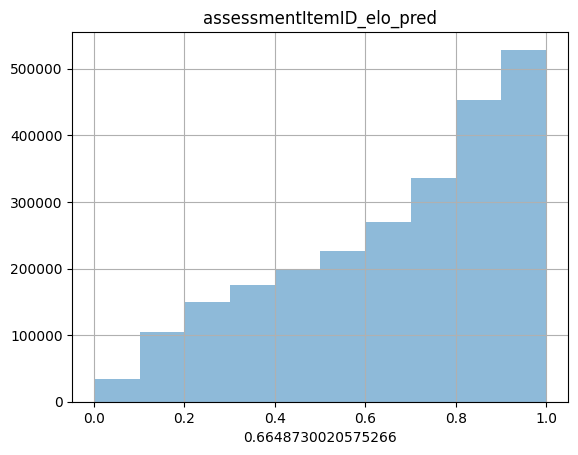

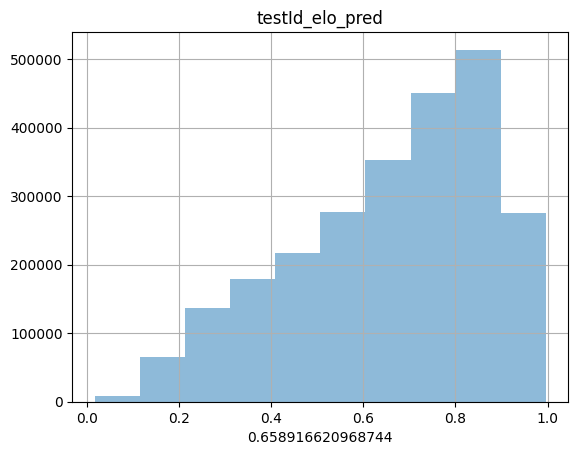

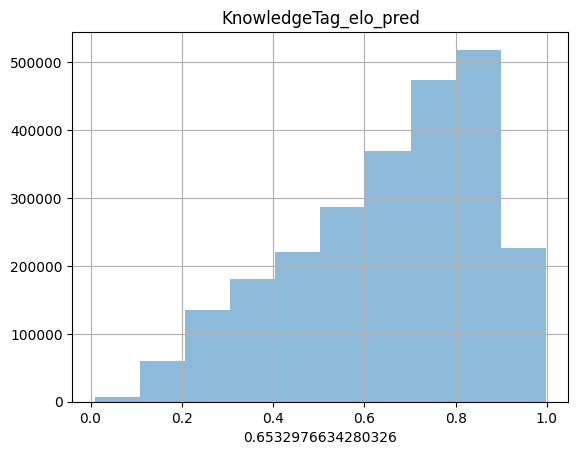

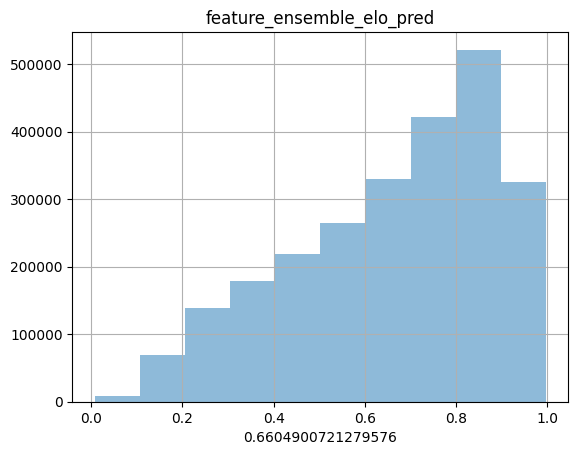

In [88]:
# 히스토그램
based_features = ["assessmentItemID", "testId", "KnowledgeTag", "feature_ensemble"]
for granularity_feature_name in based_features:
    fig = plt.figure()
    # ax = fig.add_subplot()
    # feature_mean = (np.mean(data[f"{granularity_feature_name}_elo_pred"]))
    # ax.axhline(feature_mean,label='Mean')
    plt.xlabel(np.mean(data[f"{granularity_feature_name}_elo_pred"]))
    plt.title(f"{granularity_feature_name}_elo_pred")
    data[f"{granularity_feature_name}_elo_pred"].hist(alpha=0.5)

In [89]:
student_parameter

[{0: {'theta': 0.5782017555510017, 'nb_answers': 745},
  1: {'theta': 2.1025073162942265, 'nb_answers': 879},
  2: {'theta': 0.6086452681385353, 'nb_answers': 276},
  3: {'theta': 0.4174784091170466, 'nb_answers': 826},
  4: {'theta': 0.7311986232373562, 'nb_answers': 671},
  5: {'theta': 1.02281526325187, 'nb_answers': 833},
  6: {'theta': -0.375971580748328, 'nb_answers': 887},
  7: {'theta': 0.5587652147317588, 'nb_answers': 812},
  8: {'theta': 0.5301026065955229, 'nb_answers': 536},
  9: {'theta': 0.30462088023287665, 'nb_answers': 867},
  10: {'theta': 1.7346658843778298, 'nb_answers': 370},
  11: {'theta': 0.5535590538960496, 'nb_answers': 605},
  12: {'theta': 0.28358474732215616, 'nb_answers': 939},
  13: {'theta': -0.12404895463616415, 'nb_answers': 1317},
  14: {'theta': 0.7432125546632152, 'nb_answers': 662},
  15: {'theta': 0.35443504291855443, 'nb_answers': 1218},
  16: {'theta': 1.4709594745404853, 'nb_answers': 1153},
  17: {'theta': 1.531786256635937, 'nb_answers': 126

In [90]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def probability_of_good_answer(theta, beta, left_asymptote):
    return left_asymptote + (1 - left_asymptote) * sigmoid(theta - beta)

In [91]:
_test_data = test_data[test_data["answerCode"] == -1]

In [92]:
ANSWER_PATH = "/opt/ml/input/data/custom_answer.csv"
threshold = 0.5
answer = pd.read_csv(ANSWER_PATH)

In [93]:
type(answer["prediction"].to_numpy())

numpy.ndarray

In [94]:
# SAVE OUTPUT
output_dir = "/opt/ml/input/ELO_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
dtime = datetime.now().microsecond

feature_preds = []

based_features = ["assessmentItemID", "testId", "KnowledgeTag"]
for i, granularity_feature_name in enumerate(based_features):
    pred = [
        probability_of_good_answer(
            student_parameter[i][student]["theta"], item_parameters[i][item]["beta"], 0
        )
        for student, item in zip(
            _test_data.userID.values, _test_data[granularity_feature_name].values
        )
    ]
    print(len(pred))
    y_pred, y = np.array(pred), answer["prediction"].to_numpy()

    auc, acc = roc_auc_score(y, y_pred), accuracy_score(
        y, pd.Series(y_pred).apply(lambda x: 1 if x > threshold else 0)
    )
    print(f"auc : {auc} \t\t acc : {acc}")

    write_path = os.path.join(
        output_dir, f"ELO_submission_{granularity_feature_name}_{dtime}.csv"
    )
    with open(write_path, "w", encoding="utf8") as w:
        print("writing prediction : {}".format(write_path))
        w.write("id,prediction\n")
        for id, p in enumerate(np.array(pred)):
            w.write("{},{}\n".format(id, p))

    feature_preds.append(np.array(pred))

feature_ensemble_pred = (
    feature_preds[0] * 0.9 + feature_preds[1] * 0.05 + feature_preds[2] * 0.05
)

y_pred, y = feature_ensemble_pred, answer["prediction"].to_numpy()
auc, acc = roc_auc_score(y, y_pred), accuracy_score(
    y, pd.Series(y_pred).apply(lambda x: 1 if x > threshold else 0)
)
print(f"auc : {auc} \t\t acc : {acc}")

write_path = os.path.join(output_dir, f"ELO_submission_feature_ensemble_{dtime}.csv")
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(feature_ensemble_pred):
        w.write("{},{}\n".format(id, p))

744
auc : 0.7023986306079603 		 acc : 0.6209677419354839
writing prediction : /opt/ml/input/ELO_output/ELO_submission_assessmentItemID_899208.csv
744
auc : 0.7841086150267368 		 acc : 0.7150537634408602
writing prediction : /opt/ml/input/ELO_output/ELO_submission_testId_899208.csv
744
auc : 0.769112601771724 		 acc : 0.6948924731182796
writing prediction : /opt/ml/input/ELO_output/ELO_submission_KnowledgeTag_899208.csv
auc : 0.7116815285692341 		 acc : 0.6397849462365591
writing prediction : /opt/ml/input/ELO_output/ELO_submission_feature_ensemble_899208.csv


In [95]:
data["feature_ensemble_elo_pred"]

0          0.972586
1          0.960146
2          0.947019
3          0.960962
4          0.954083
             ...   
2266581    0.450867
2266582    0.621379
2266583    0.609187
2266584    0.670626
2266585    0.527107
Name: feature_ensemble_elo_pred, Length: 2476706, dtype: float64